In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train = pd.read_csv(r"C:/Users/Dileemre/Desktop/jupyter/DATAAITEAM/train.csv", dtype = np.float32)

targets_np = train.label.values
features_np = train.loc[:,train.columns != "label"].values/255

features_train, features_test, targets_train, targets_test = train_test_split(features_np,
                                                                             targets_np,
                                                                             test_size = 0.2,
                                                                             random_state = 42)

x_train = torch.from_numpy(features_train)
y_train = torch.from_numpy(targets_train).type(torch.LongTensor)

x_test = torch.from_numpy(features_test)
y_test = torch.from_numpy(targets_test).type(torch.LongTensor)

batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)

train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

In [3]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity="relu")
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out
    

In [4]:
input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)
error = nn.CrossEntropyLoss()
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [5]:
seq_dim = 28
loss_list = []
iter_list = []
acc_list = []
count = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        train = Variable(images.view(-1, seq_dim, input_dim))
        labels = Variable(labels)
        
        optimizer.zero_grad()
        outputs = model(train)
        loss = error(outputs, labels)
        loss.backward()
        optimizer.step()
        count += 1
        
        if count % 50 == 0:
            correct = 0
            total = 0
            for images, labels in test_loader:
                test = Variable(images.view(-1, seq_dim, input_dim))
                outputs = model(test)
                predicted = torch.max(outputs.data, 1)[1]
                total += len(labels)
                correct += (predicted == labels).sum()
                
            acc = 100 * correct / total
            
            loss_list.append(loss.data)
            iter_list.append(count)
            acc_list.append(acc)
            if count % 500 == 0:
                print("Iter: {} Loss: {}, Acc: {}".format(count, loss.data, acc))

Iter: 500 Loss: 1.667345404624939, Acc: 31.178571701049805
Iter: 1000 Loss: 0.9318240880966187, Acc: 67.76190185546875
Iter: 1500 Loss: 0.5821564197540283, Acc: 82.45237731933594
Iter: 2000 Loss: 0.42937904596328735, Acc: 88.25
Iter: 2500 Loss: 0.19398380815982819, Acc: 89.80952453613281
Iter: 3000 Loss: 0.1023247241973877, Acc: 92.69047546386719
Iter: 3500 Loss: 0.2650604248046875, Acc: 92.79762268066406
Iter: 4000 Loss: 0.18655887246131897, Acc: 92.3452377319336
Iter: 4500 Loss: 0.2713298797607422, Acc: 94.8452377319336
Iter: 5000 Loss: 0.14636129140853882, Acc: 94.30952453613281
Iter: 5500 Loss: 0.1713278591632843, Acc: 95.10713958740234
Iter: 6000 Loss: 0.15884904563426971, Acc: 95.58333587646484
Iter: 6500 Loss: 0.04221576824784279, Acc: 96.21428680419922
Iter: 7000 Loss: 0.2245042622089386, Acc: 95.91666412353516
Iter: 7500 Loss: 0.0677994042634964, Acc: 96.16666412353516
Iter: 8000 Loss: 0.2183118313550949, Acc: 95.97618865966797
Iter: 8500 Loss: 0.06749698519706726, Acc: 96.059

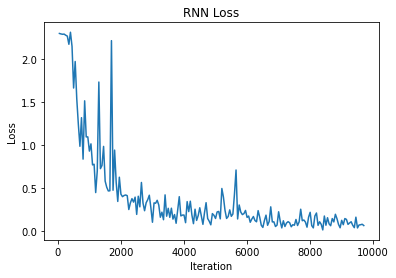

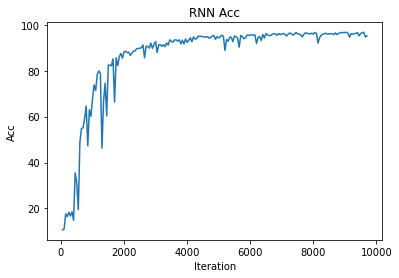

In [6]:
plt.plot(iter_list, loss_list)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("RNN Loss")
plt.show()

plt.plot(iter_list, acc_list)
plt.xlabel("Iteration")
plt.ylabel("Acc")
plt.title("RNN Acc")
plt.show()